# Convergence and Optimality Analysis of Low-Dimensional Generative Adversarial Networks using Error Function Integrals

## Requirements

Use `requirements.txt` file preferably in virtual environment.

In order to do that in the current folder, for Ubuntu:
```
$ sudo apt install virtualenv
$ virtualenv venv
$ source venv/bin/activate
(venv)$ pip install -r requirements.txt
(venv)$ python -m ipykernel install --user --name=venv
```

Launch from command prompt: 
```bash
(venv)$ jupyter notebook
```

or open it within VSCode with [Jupyter extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) or any other favorite method. Please make sure that the Jupyter kernel points to your environment (select it from the kernel menu).

## Imports

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.io import savemat 
from tqdm import tqdm

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
sys.path.append('src')

In [51]:
from sgd import SGD
from gan import sample_xz

## Common notes
Objective function (from Goodfellow's paper):
$$
V[G,D] = \mathbb{E}_x \log D(x) + \mathbb{E}_z \log(1 - D(G(z))
$$

The goal is to optimize
$$
\min_G \max_D V[G, D]
$$

The assumption of Goodfellow's paper is that we can find an algorithm which finds globally optimal $D^*, G^*$. Let's see if we can optimize for some simple case, introducing some new levels of complexity if we need them. If the approach of Gf is formulated for a very common case, it should work for a basic one.

A least squares GAN cost function is:
$$
V[G, D] = E_x D^2(x) + E_z [1 - D(G(z))]^2
$$


## Cost function computed using sampling
Easiest way (the one, which Goodfellow also follows):
$$
V[G,D] = {1 \over m} \sum_{i = 1}^m
D^2(x_i) + [1 - D(G(z_i))]^2
$$

## SGD implementation
Here we implement vanilla SGD for the example above.

SGD procedure:

In [52]:
def run_SGD(config_gan, config_sgd, x, z):
  c = [v[1] for v in config_sgd.items()]
  a_initial, b_initial, g_initial, h_initial, n_steps = [v[1] for v in config_gan.items()]
  abgh = SGD(x, z, a_initial, b_initial, c, g_initial, h_initial, n_steps)
  path = [val for val in abgh]
  a_path = [a_initial]
  b_path = [b_initial]
  g_path = [g_initial]
  h_path = [h_initial]
  a_path += [val[0] for val in path]
  b_path += [val[1] for val in path]
  g_path += [val[2] for val in path]
  h_path += [val[3] for val in path]
  return a_path, b_path, g_path, h_path

In [53]:
def run_SGD_batch(config_gan, config_sgd, n_runs=5, n_samples=1_000):
  a_paths = []
  b_paths = []
  g_paths = []
  h_paths = []
  for _ in tqdm(range(n_runs)):
    x, z = sample_xz(config_gan, n_samples=n_samples)
    a_hat, b_hat, g_hat, h_hat = run_SGD(config_sgd, config_gan, x, z)
    a_paths += [a_hat]
    b_paths += [b_hat]
    g_paths += [g_hat]
    h_paths += [h_hat]
  return a_paths, b_paths, g_paths, h_paths

## Plot utility

In [59]:
def plot_and_save_mat(config_gan, config_sgd, a_paths, b_paths, g_paths, h_paths):
    fig, _ = plt.subplots()
    plt.grid(True)

    plt.plot(np.array(a_paths).transpose(), color='blue')
    plt.plot([], [], label='$a$ MC', color='blue')
    plt.plot(np.array(b_paths).transpose(), color='red')
    plt.plot([], [], label='$b$ MC', color='red')
    plt.plot(np.array(g_paths).transpose(), color='lightblue')
    plt.plot([], [], label='$g$ MC', color='lightblue')
    plt.plot(np.array(h_paths).transpose(), color='peachpuff')
    plt.plot([], [], label='$h$ MC', color='peachpuff')
    n_steps = config_sgd['n_steps'] - 1
    plt.plot(n_steps, 1.0/config_gan["c"], marker='o', linestyle='None',
             label='optimal $g^*$', color='lightblue', markeredgecolor='black')
    plt.plot(n_steps, 0, marker='o', linestyle='None',
             label='optimal $h^*$', color='orange', markeredgecolor='black')
    plt.legend()
    #ofname = f'python_gh_test_case_c_{config_gan["c"]}_g_{config_sgd["g_initial"]}_h{config_sgd["h_initial"]}'
    #fig.savefig(os.path.join('content', ofname + '.pdf'), format='pdf')
    #savemat(os.path.join('content', ofname + '.mat'), {'g_paths': g_paths, 'h_paths': h_paths})
    plt.show()

## Test case implementation

### MC SGD experiment 1

In [55]:
config_gan = {
    "c": 0.5
}
config_sgd = {
    "a_initial": 0.7,
    "b_initial": -1.5,
    "g_initial": 1.9,
    "h_initial": 1.1,
    "n_steps": 150
}

In [56]:
a_paths, b_paths, g_paths, h_paths = run_SGD_batch(config_gan=config_gan, config_sgd=config_sgd)

100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


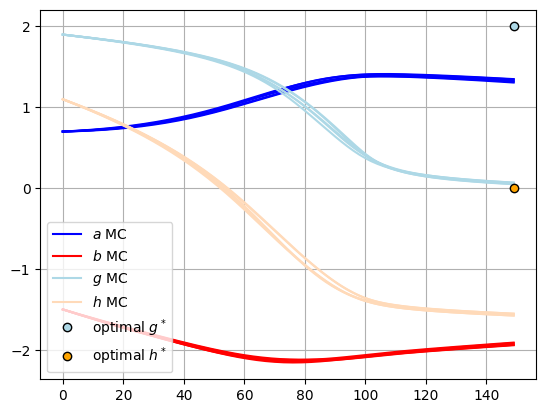

In [60]:
plot_and_save_mat(config_gan=config_gan,
                  config_sgd=config_sgd,
                  a_paths=a_paths,
                  b_paths=b_paths,
                  g_paths=g_paths,
                  h_paths=h_paths)